In [1]:
#Montamos el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Buscamos la direccion de dataset
!ls /content/drive/MyDrive/Colab_Notebooks/Proyectos/datasets/rayos-x_pulmones_neumonia/chest_xray

chest_xray  __MACOSX  test  train  val


In [3]:
#Importamos la librerias que necesitamos
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation, BatchNormalization

In [4]:
#Guardamos las direcciones en variables
train_dir = '/content/drive/MyDrive/Colab_Notebooks/Proyectos/datasets/rayos-x_pulmones_neumonia/chest_xray/train'
test_dir = '/content/drive/MyDrive/Colab_Notebooks/Proyectos/datasets/rayos-x_pulmones_neumonia/chest_xray/test'

In [5]:
#Creamos el data gen para cada uno 
# train_datagen = ImageDataGenerator(rescale= 1/255)
#Creamos el datagen de train
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale = 1/255, validation_split= 0.2)

In [6]:
#Creamos los generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (250, 250), #Antes 180, 180,
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb",
    subset = "training"
)
val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (250, 250), #probar con 299, 299 original 180
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb",
    subset = "validation"
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (250, 250), #probar con 299, 299
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb"
)

Found 5216 images belonging to 2 classes.
Found 124 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
#creamos una funcion para visualizar imagenes
def plot_image(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0])
    ax.axis("off")
  plt.tight_layout()
  plt.show()

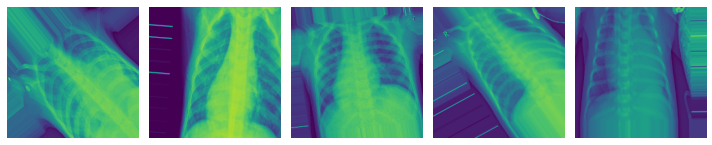

In [8]:
#Mostramos las imagenes
sample_training_images, _ = next(train_generator)
plot_image(sample_training_images[:5])

In [9]:
#Ahora importamos el modelo para hacer transferencia de aprendizaje
from tensorflow.keras.applications.nasnet import NASNetLarge

pre_trained_model = tf.keras.applications.NASNetLarge(
    include_top=False,
    weights='imagenet',
    input_tensor= tf.keras.layers.Input(shape=(250,250,3)),
    pooling='max'
)

for layer in pre_trained_model.layers:
  layer.trainable = False

  #Mostramos la arquitectura de la red neuronal
  # pre_trained_model.summary()

343621632/343610240 [==============================] - 3s 0us/step


In [10]:
#normal_concat_18

#Separamos la red para ponerle capas finales, reutilizando el modelo
last_layers = pre_trained_model.get_layer("normal_concat_18")
last_output = last_layers.output

In [11]:
#Creamos las ultimas capas del modelo

#Conv 1
x = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(last_output)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

#Conv 2
x = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
x = tf.keras.layers.Dropout(0.5)

#Conv 3
x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(last_output)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

#Conv 4
x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
x = tf.keras.layers.Dropout(0.5)

#Conv 5
x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(last_output)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

#Conv 6
x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.5)(x)

#Flatten and Fully Conect
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

#Juntamos el modelo pre entrenado y las ultimas capas que cree
model_keras = tf.keras.Model(pre_trained_model.input, x)

In [12]:
model_keras.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [13]:
#Hacemos un callback checkpoint
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

#Path del checkpoint
checkpoint_path = '/tmp/checkpoint'

best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)

In [14]:
#Entrenamos el modelo 
history = model_keras.fit(
    train_generator,
    epochs=100,
    callbacks=[best_checkpoint],
    validation_data = val_generator
)

Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.8432 
Epoch 1: val_accuracy improved from -inf to 0.74194, saving model to /tmp/checkpoint
41/41 [==============================] - 614s 14s/step - loss: 0.6697 - accuracy: 0.8432 - val_loss: 1.7325 - val_accuracy: 0.7419
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.9120
Epoch 2: val_accuracy improved from 0.74194 to 0.81452, saving model to /tmp/checkpoint
41/41 [==============================] - 241s 6s/step - loss: 0.4483 - accuracy: 0.9120 - val_loss: 0.6911 - val_accuracy: 0.8145
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.9335
Epoch 3: val_accuracy improved from 0.81452 to 0.83065, saving model to /tmp/checkpoint
41/41 [==============================] - 242s 6s/step - loss: 0.3992 - accuracy: 0.9335 - val_loss: 0.6249 - val_accuracy: 0.8306
Epoch 4/100
41/41 [==============================] - ETA: 0s -

KeyboardInterrupt: ignored

Pare aqui el entrenamiento porque tardaria demasiado, ya lo habia entrenado y guardado el modelo anteriormente pero al hacer otras pruebas se borro la visualización del modelo que tuvo mejor resultado pero abajo muestro los resultado que tiene con datos que nunca ha visto previamente.

In [15]:
model_keras.evaluate(test_generator)

5/5 [==============================] - 124s 28s/step - loss: 0.3299 - accuracy: 0.9215


[0.32986146211624146, 0.9214743375778198]

In [20]:
# model_keras.load_weights(checkpoint_path)

In [21]:
# model_keras.evaluate(test_generator)

In [18]:
# #Guardamos el modelo
# model_keras.save('drive/MyDrive/Colab_Notebooks/Modelos_entrenados/neumonia_92.79%.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
new_model = keras.models.load_model('drive/MyDrive/Colab_Notebooks/Modelos_entrenados/neumonia_92.79%.h5')

In [19]:
new_model.evaluate(test_generator)

5/5 [==============================] - 35s 5s/step - loss: 0.2864 - accuracy: 0.9279


[0.286357045173645, 0.9278846383094788]